# Siamese Network with HRSCD dataset

In [ ]:
#! git clone https://github.com/rcdaudt/fully_convolutional_change_detection.git

Cloning into 'fully_convolutional_change_detection'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Receiving objects: 100% (17/17), 12.27 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
#!rm -rf fully_convolutional_change_detection

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 3.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/MVA/IA_env/src

/content/drive/MyDrive/MVA/IA_env/src


In [ ]:
# Imports

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr

# Models
from unet import Unet
from siamunet_conc import SiamUnet_conc
from siamunet_diff import SiamUnet_diff
from fresunet import FresUNet

# Other
import os
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
from IPython import display
import time
from itertools import chain
import time
import warnings
from pprint import pprint
from torch.utils.data import Subset
import rasterio


import warnings
warnings.filterwarnings("ignore")
from PIL import Image

# import T
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable


IMPORTS OK


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
# load one image and print shape, value range for img tif 2006, img 2012 and mask

img_path = '../data/HRSCD/train/images/2006/0305-6785.tif'
mask_path = '../data/HRSCD/train/targets/0305-6785.tif'

# use rasterio to load image
img = rasterio.open(img_path)
mask = rasterio.open(mask_path)

# shape, range of values
print('Image shape:', img.shape)
print('Image number of channels:', img.count)
print('Image value range:', img.read().min(), img.read().max())
print('Image values type:', img.dtypes)
print('Image type:', type(img))

print('Mask shape:', mask.shape)
print('Mask number of channels:', mask.count)
print('Mask value range:', mask.read().min(), mask.read().max())
print('Mask values type:', mask.dtypes)
print('Mask type:', type(mask))

Image shape: (10000, 10000)
Image number of channels: 3
Image value range: 0 255
Image values type: ('uint8', 'uint8', 'uint8')
Image type: <class 'rasterio.io.DatasetReader'>
Mask shape: (10000, 10000)
Mask number of channels: 1
Mask value range: 0 1
Mask values type: ('uint16',)
Mask type: <class 'rasterio.io.DatasetReader'>


In [ ]:
class HRSCD_dataset(Dataset):
    def __init__(self, images_dir_2006, images_dir_2012, masks_dir, transform=None):
        self.images_dir_2006 = images_dir_2006
        self.images_dir_2012 = images_dir_2012
        self.masks_dir = masks_dir
        self.transform = transform
        self.ids = os.listdir(images_dir_2012)
        #self.transform = transform
        self.n_pix = 0
        self.true_pix = 0
        self.calculate_weights()

    def calculate_weights(self):
        for img_id in self.ids:
            mask_path = os.path.join(self.masks_dir, img_id)
            mask = Image.open(mask_path)
            mask = mask.resize((256, 256), resample=Image.NEAREST)
            mask = np.array(mask)

            # Assuming mask is binary (0 or 1). Adjust the condition if necessary.
            self.true_pix += np.sum(mask == 1)
            self.n_pix += mask.size

        FP_MODIFIER = 10  # Adjust this value based on your requirement
        self.weights = [FP_MODIFIER * 2 * self.true_pix / self.n_pix, 2 * (self.n_pix - self.true_pix) / self.n_pix]


    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        image_path_2006 = os.path.join(self.images_dir_2006, self.ids[i])
        image_path_2012 = os.path.join(self.images_dir_2012, self.ids[i])
        mask_path = os.path.join(self.masks_dir, self.ids[i])

        #use PIL
        img_2006 = Image.open(image_path_2006)
        img_2012 = Image.open(image_path_2012)
        mask = Image.open(mask_path)


        # resize img to 256x256
        img_2006 = img_2006.resize((256, 256))
        img_2012 = img_2012.resize((256, 256))
        # resize mask  nearest neighbor interpolation
        mask = mask.resize((256, 256), resample=Image.NEAREST)
        # turn to tensor
        img_2006 = T.ToTensor()(img_2006)
        img_2012 = T.ToTensor()(img_2012)
        mask = T.ToTensor()(mask)
        # turn mask to int16
        # mask = mask.astype(np.int16)

        sample = {'I1': img_2006, 'I2': img_2012, 'label': mask}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
import torchvision.transforms as T
bs = 10

train_dataset = HRSCD_dataset(
    images_dir_2006 = '../data/HRSCD/train/images/2006',
    images_dir_2012 = '../data/HRSCD/train/images/2012',
    masks_dir = '../data/HRSCD/train/targets',
)

val_dataset = HRSCD_dataset(
    images_dir_2006 = '../data/HRSCD/valid/images/2006',
    images_dir_2012 = '../data/HRSCD/valid/images/2012',
    masks_dir = '../data/HRSCD/valid/targets',
)

test_dataset = HRSCD_dataset(
    images_dir_2006 = '../data/HRSCD/test/images/2006',
    images_dir_2012 = '../data/HRSCD/test/images/2012',
    masks_dir = '../data/HRSCD/test/targets',
)

In [ ]:
train_indices = list(range(100))
train_subset = Subset(train_dataset, train_indices)

val_indices = list(range(20))
val_subset = Subset(val_dataset, val_indices)

test_subset = Subset(test_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=bs, shuffle=True)


In [ ]:
# check
sample = next(iter(train_loader))
print(sample['I1'].shape, sample['I2'].shape, sample['label'].shape)

torch.Size([10, 3, 256, 256]) torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])


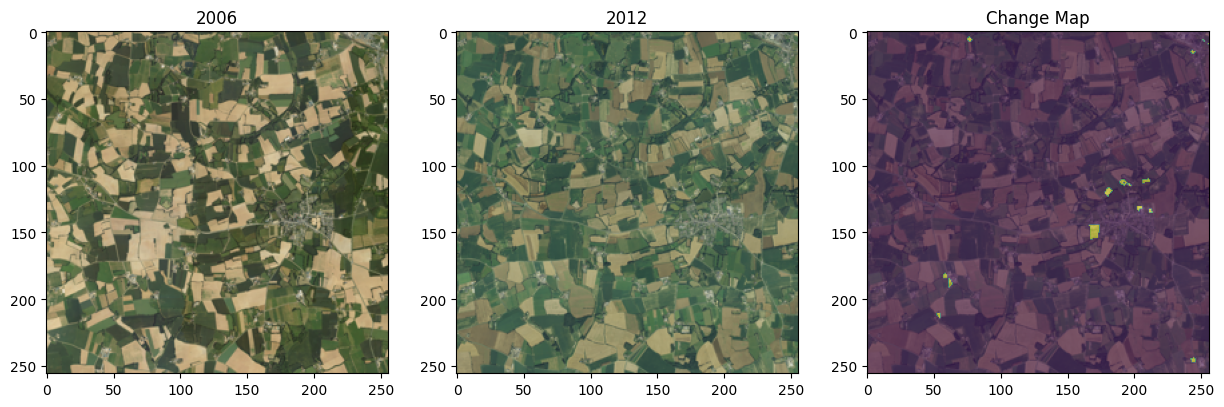

In [ ]:
# plot sample['I1'], sample['I2'], sample['label'] in the same line. Legend: 2006, 2012, binary change map

def plot_sample(sample):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(sample['I1'][0].permute(1, 2, 0))
    ax[0].set_title('2006')
    ax[1].imshow(sample['I2'][0].permute(1, 2, 0))
    ax[1].set_title('2012')
    ax[2].imshow(sample['I2'][0].permute(1, 2, 0))
    # color only when mask is 1
    ax[2].imshow(sample['label'][0].permute(1, 2, 0), alpha=0.5)#, cmap='Reds')
    ax[2].set_title('Change Map')
    plt.show()

plot_sample(sample)

In [ ]:

net, net_name = SiamUnet_diff(3, 2), 'FC-Siam-diff'

net.to(device)
weights = torch.FloatTensor(train_dataset.weights).to(device)
criterion = nn.NLLLoss(weight=weights)
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-2)
num_epochs = 10

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        I1 = Variable(batch['I1'].float().to(device))
        I2 = Variable(batch['I2'].float().to(device))
        label = torch.squeeze(Variable(batch['label'].to(device)))

        optimizer.zero_grad()
        output = model(I1, I2)
        loss = criterion(output, label.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    return train_loss

def valid(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    tot_count = 0

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    with torch.no_grad():
        for batch in val_loader:
            I1 = Variable(batch['I1'].float().to(device))
            I2 = Variable(batch['I2'].float().to(device))
            label = torch.squeeze(Variable(batch['label'].to(device)))

            output = model(I1, I2)
            loss = criterion(output, label.long())
            val_loss += loss.data * batch['label'].size(0)
            tot_count += batch['label'].size(0)

            _, predicted = torch.max(output.data, 1)
            pr = (predicted.int() > 0).cpu().numpy()
            gt = (label.data.int() > 0).cpu().numpy()

            tp += np.logical_and(pr, gt).sum()
            tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
            fp += np.logical_and(pr, np.logical_not(gt)).sum()
            fn += np.logical_and(np.logical_not(pr), gt).sum()

    val_loss /= tot_count
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    return val_loss, f1_score

In [ ]:
train_losses = []
val_losses = []
f1_scores = []

for epoch in range(num_epochs):
    train_loss = train(net, train_loader, criterion, optimizer, device)
    val_loss, f1_score = valid(net, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    f1_scores.append(f1_score)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1 Score: {f1_score:.4f}")

Epoch 1/10: Train Loss: 0.0380, Val Loss: 0.2398, F1 Score: 0.0000
Epoch 2/10: Train Loss: 0.0353, Val Loss: 0.2347, F1 Score: 0.0006
Epoch 3/10: Train Loss: 0.0335, Val Loss: 0.2273, F1 Score: 0.0000
Epoch 4/10: Train Loss: 0.0321, Val Loss: 0.2468, F1 Score: 0.0073
Epoch 5/10: Train Loss: 0.0316, Val Loss: 0.2423, F1 Score: 0.0082
Epoch 6/10: Train Loss: 0.0302, Val Loss: 0.2205, F1 Score: 0.0000


KeyboardInterrupt: 

In [ ]:
train_losses = []
val_losses = []
f1_scores = []

for epoch in range(num_epochs):
    train_loss = train(net, train_loader, criterion, optimizer, device)
    val_loss, f1_score = valid(net, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    f1_scores.append(f1_score)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1 Score: {f1_score:.4f}")

Epoch 1/10: Train Loss: 0.0988, Val Loss: 0.5259, F1 Score: 0.0033
Epoch 2/10: Train Loss: 0.0555, Val Loss: 0.3672, F1 Score: 0.0084
Epoch 3/10: Train Loss: 0.0406, Val Loss: 0.2794, F1 Score: 0.0069
Epoch 4/10: Train Loss: 0.0337, Val Loss: 0.2409, F1 Score: 0.0011


KeyboardInterrupt: 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

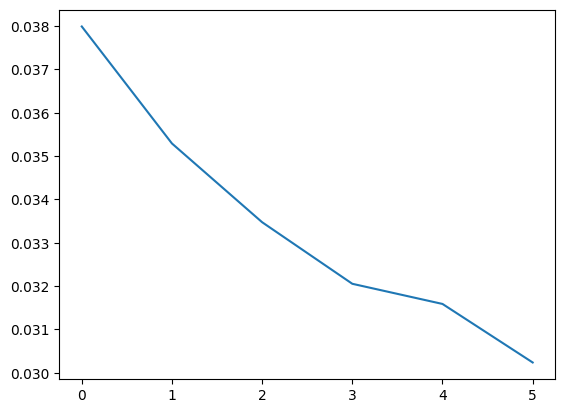

In [ ]:
# Loss obtained with 100 images in the training, 10 in the validation and 10 in the test.
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, val_losses, f1_scores = train_and_validate(net, train_loader, val_loader, criterion, optimizer, device, num_epochs)


Epoch 1/10: Train Loss: 0.0330, Val Loss: 0.3019, F1 Score: 0.0017
Epoch 2/10: Train Loss: 0.0298, Val Loss: 0.2742, F1 Score: 0.0013
Epoch 3/10: Train Loss: 0.0322, Val Loss: 0.2477, F1 Score: 0.0014
Epoch 4/10: Train Loss: 0.0261, Val Loss: 0.2285, F1 Score: 0.0015
Epoch 5/10: Train Loss: 0.0280, Val Loss: 0.2131, F1 Score: 0.0008
Epoch 6/10: Train Loss: 0.0246, Val Loss: 0.1935, F1 Score: nan
Epoch 7/10: Train Loss: 0.0225, Val Loss: 0.1764, F1 Score: nan
Epoch 8/10: Train Loss: 0.0246, Val Loss: 0.1619, F1 Score: nan
Epoch 9/10: Train Loss: 0.0236, Val Loss: 0.1518, F1 Score: nan
Epoch 10/10: Train Loss: 0.0267, Val Loss: 0.1491, F1 Score: nan


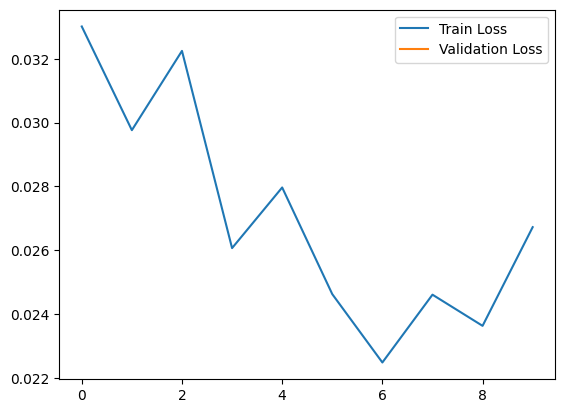

In [ ]:
# Loss obtained with 14 images in the training, 7 in the validation and 7 in the test.
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()